# Data Exploration of the StatsBomb Open Data Dataset

This notebook focuses on a **data exploration** of the [StatsBomb dataset](https://github.com/statsbomb/open-data) using the `statsbombpy` library. The goal is to analyze and structure information related to shots taken by players, which will later serve as the foundation for developing an expected goals (xG) model.

`statsbombpy` is a Python API that provides easy access to StatsBomb’s open-data, allowing users to directly query matches, events, and other football-related information without manual downloads.

The steps taken in this notebook are explore and analyze the relevant information from the StatsBomb dataset and investigate specific matches to understand how `Shot` events are structured 

## 1) Analysis of the Dataset

In [71]:
from statsbombpy import sb
import pandas as pd
from tabulate import tabulate
from tqdm import tqdm 

import warnings
warnings.filterwarnings("ignore")

### 1.1) Exploration of Available Competitions and Seasons

Here, the exploration of the StatsBomb data was carried out to identify the available competitions and seasons in the dataset.
For each competition–season pair, the total number of matches was collected into a dataframe and printed as a summary table. Also the global number of competitions and matches are stored in the final row of the created dataframe.

In [72]:
# Load competitions
competitions = sb.competitions()
competitions.head()

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-09-28T20:46:38.893391,2025-07-06T04:26:07.636270,2025-07-06T04:26:07.636270,2024-09-28T20:46:38.893391
1,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2024-05-19T11:11:14.192381,None,None,2024-05-19T11:11:14.192381
2,1267,107,Africa,African Cup of Nations,male,False,True,2023,2024-09-28T01:57:35.846538,None,None,2024-09-28T01:57:35.846538
3,16,4,Europe,Champions League,male,False,False,2018/2019,2025-05-08T15:10:50.835274,2021-06-13T16:17:31.694,None,2025-05-08T15:10:50.835274
4,16,1,Europe,Champions League,male,False,False,2017/2018,2024-02-13T02:35:28.134882,2021-06-13T16:17:31.694,None,2024-02-13T02:35:28.134882


In [73]:
competition_list = []
competitions = sb.competitions()

# Iterate through each competition and season to gather match counts
for _, row in tqdm(competitions.iterrows(), total=competitions.shape[0], desc="Processing competitions"):

    # Collect competition and season information
    comp_id = row["competition_id"]
    season_id = row["season_id"]

    # Fetch matches for the given competition and season
    matches = sb.matches(competition_id=comp_id, season_id=season_id)

    # Append the data to rows
    competition_list.append({
        "Competition": row["competition_name"],
        "Season": row["season_name"],
        "Gender": (str(row["competition_gender"]) or "").title(),  # .title() to capitalize
        "Matches": int(matches.shape[0]),
    })

# Create a DataFrame from the competition list
df = pd.DataFrame(competition_list)

# Sort by first season year then competition
df["Season_Start"] = df["Season"].str[:4].astype(int)
df = (
    df.sort_values(["Season_Start", "Competition"])
      .drop(columns="Season_Start")
      .reset_index(drop=True)
)

# Calculate totals
total_matches = int(df["Matches"].sum())
total_pairs = len(df)  # unique (Competition, Season)
total_unique_competitions = df["Competition"].nunique()

total_row = pd.DataFrame([{
    "Competition": "TOTAL",
    "Season": f"{total_pairs} pairs | {total_unique_competitions} competitions",
    "Gender": "",
    "Matches": total_matches,
}])

df_competitions = pd.concat([df, total_row], ignore_index=True)


Processing competitions: 100%|██████████| 75/75 [00:17<00:00,  4.29it/s]


In [74]:
# Display the DataFrame as a table
df_competitions["Matches"] = df_competitions["Matches"].map("{:,}".format) # Format matches for better readability
print("\nAvailable Competitions in StatsBomb Open Data\n")
print(tabulate(df_competitions, headers="keys", tablefmt="grid", showindex=False))


Available Competitions in StatsBomb Open Data

+-------------------------+----------------------------+----------+-----------+
| Competition             | Season                     | Gender   | Matches   |
+=========================+============================+==========+===========+
| FIFA World Cup          | 1958                       | Male     | 2         |
+-------------------------+----------------------------+----------+-----------+
| FIFA World Cup          | 1962                       | Male     | 1         |
+-------------------------+----------------------------+----------+-----------+
| Champions League        | 1970/1971                  | Male     | 1         |
+-------------------------+----------------------------+----------+-----------+
| FIFA World Cup          | 1970                       | Male     | 6         |
+-------------------------+----------------------------+----------+-----------+
| Champions League        | 1971/1972                  | Male     | 1   

#### Saving the Competition DataFrame

The resulting DataFrame is saved as a `csv` file in the `/data` folder for later use.

In [75]:
import os

# Define relative path to the data folder
data_dir = os.path.join("../task1_xg/data")
os.makedirs(data_dir, exist_ok=True)

# Choose a clear filename with today's date
filename_base = "df_competitions"
csv_path = os.path.join(data_dir, f"{filename_base}.csv")

# Save DataFrame
df_competitions.to_csv(csv_path, index=False)

print(f"DataFrame saved successfully:\n- {csv_path}")

DataFrame saved successfully:
- ../task1_xg/data/df_competitions.csv


### 1.2) Load the Saved Dataset

In [76]:
from pathlib import Path

# LOAD THE SAVED COMPETITION DATA

# Define the source path for the saved DataFrame
src_path = Path("../task1_xg/data/df_competitions.csv")

print(f"Loading {src_path.name}")

# Load DataFrame
df_comp = pd.read_csv(src_path)

# Clean up DataFrame (e.g., remove TOTAL row, extract years, convert matches to numeric)
df_comp = (
    df_comp
    .query("Competition != 'TOTAL'")  # drop TOTAL row
    .assign(
        Season_Start=lambda d: pd.to_numeric(d["Season"].astype(str).str.extract(r"(\d{4})")[0], errors="coerce"),      # extract starting year, errors='coerce' to handle any non-numeric values
        Matches=lambda d: pd.to_numeric(d["Matches"].astype(str).str.replace(r"\D", "", regex=True), errors="coerce")   # remove non-numeric characters
    )
    .astype({"Season_Start": "Int64", "Matches": "Int64"})
    .reset_index(drop=True)
)

print(f"Rows: {len(df_comp)} | Unique competitions: {df_comp['Competition'].nunique()}")

df_comp.head()


Loading df_competitions.csv
Rows: 75 | Unique competitions: 21


,Competition,Season,Gender,Matches,Season_Start
0,FIFA World Cup,1958,Male,2,1958
1,FIFA World Cup,1962,Male,1,1962
2,Champions League,1970/1971,Male,1,1970
3,FIFA World Cup,1970,Male,6,1970
4,Champions League,1971/1972,Male,1,1971


### 1.3) Competition and Match Distribution

The saved competition dataset is used to create two main visualizations:

1. **Competitions and matches by competition type** – this shows, for each competition, how many seasons it has appeared in and the total number of matches played within it.

2. **Competitions and matches over time** – this illustrates how the number of competitions and the total number of matches have changed across different seasons.

#### Plot Competitions and Matches by Competition Type

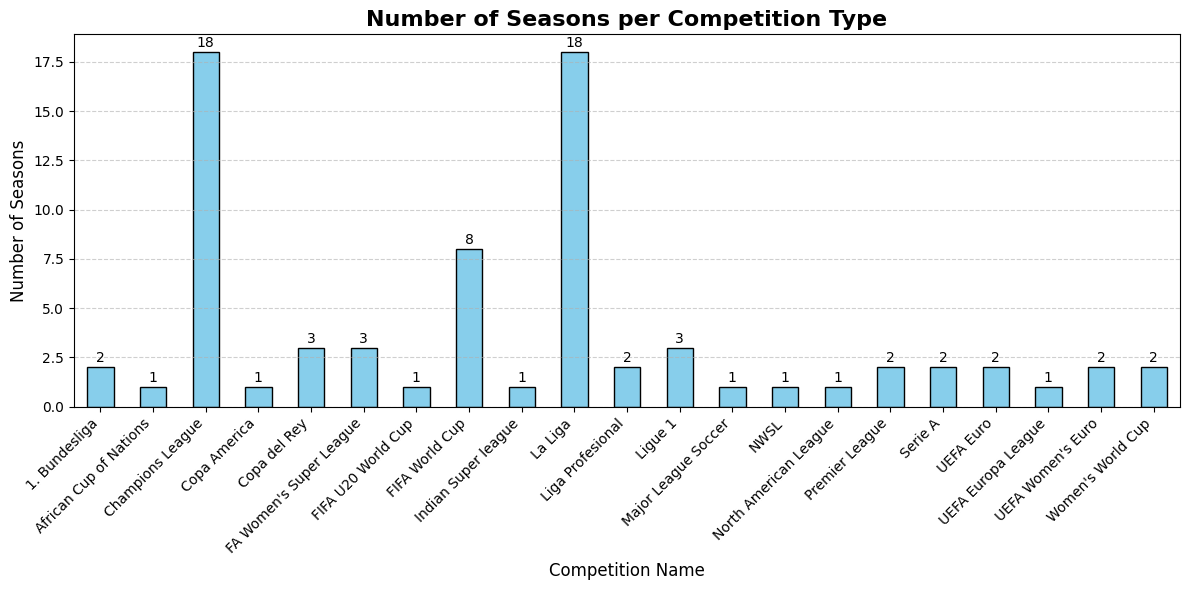

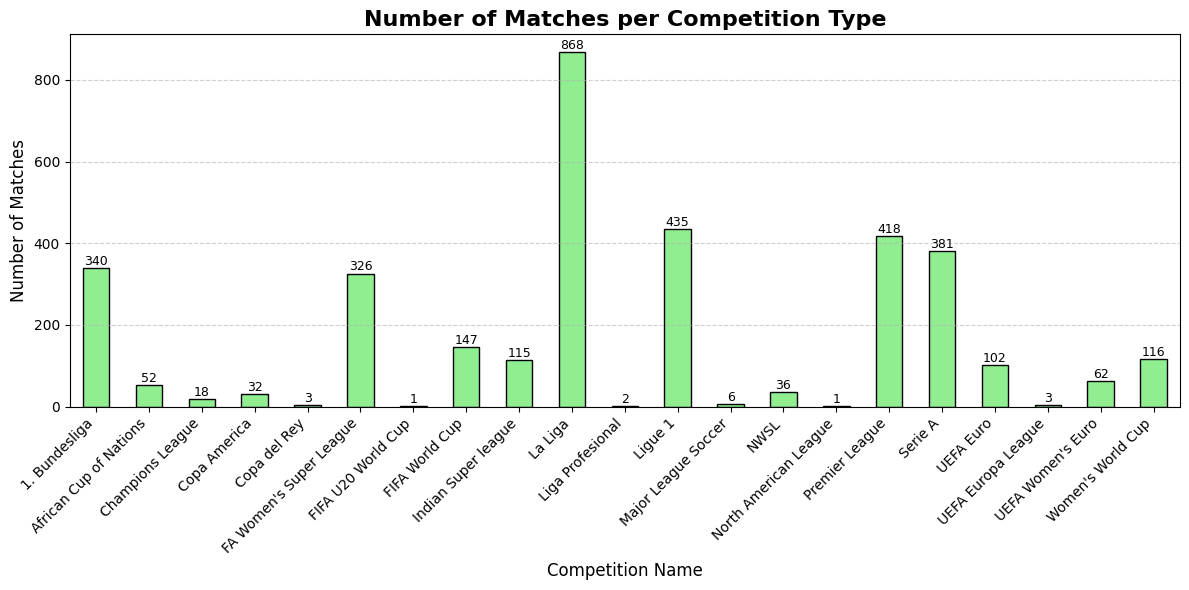

In [77]:
import matplotlib.pyplot as plt

# Check if df_comp exists in the current environment
if "df_comp" not in globals():
    raise RuntimeError("df_comp not found. Please run cell \"1.3) Load the saved dataset first\"")

# Count how many seasons exist for each competition
seasons_per_comp = df_comp.groupby("Competition")["Season_Start"].nunique()

# Sum of matches for each competition
matches_per_comp = df_comp.groupby("Competition")["Matches"].sum()

# Plot: number of seasons per competition
plt.figure(figsize=(12,6))
bars = seasons_per_comp.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Number of Seasons per Competition Type", fontsize=16, weight="bold")
plt.ylabel("Number of Seasons", fontsize=12)
plt.xlabel("Competition Name", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Add values above bars
for i, v in enumerate(seasons_per_comp):
    plt.text(i, v + 0.1, str(v), ha="center", va="bottom", fontsize=10, color="black")  # +0.2 to avoid overlap

plt.tight_layout()
plt.show()


# Plot: number of matches per competition
plt.figure(figsize=(12,6))
bars = matches_per_comp.plot(kind="bar", color="lightgreen", edgecolor="black")

plt.title("Number of Matches per Competition Type", fontsize=16, weight="bold")
plt.ylabel("Number of Matches", fontsize=12)
plt.xlabel("Competition Name", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Add values above bars
for i, v in enumerate(matches_per_comp):
    plt.text(i, v + 0.1, str(v), ha="center", va="bottom", fontsize=9)  # +0.2 to avoid overlap

plt.tight_layout()
plt.show()

#### Plot Competitions and Matches by Year

> **NOTE**: Competitions and matches are aggregated by **season start year** (the first 4-digit year in the "Season" column), so each competition is counted according to its starting year.  

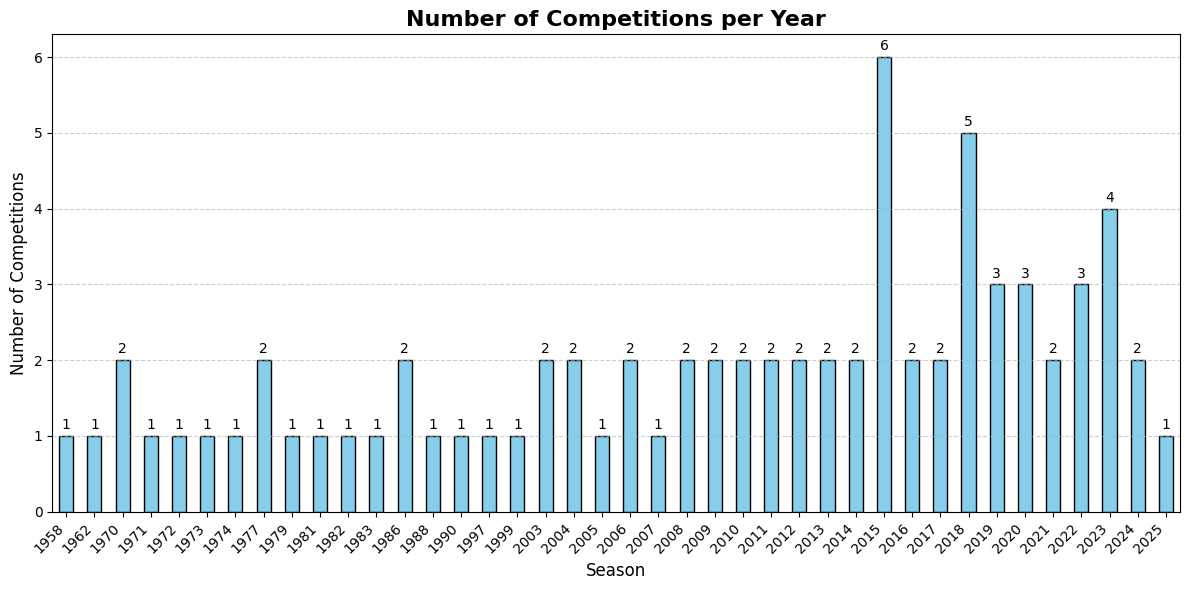

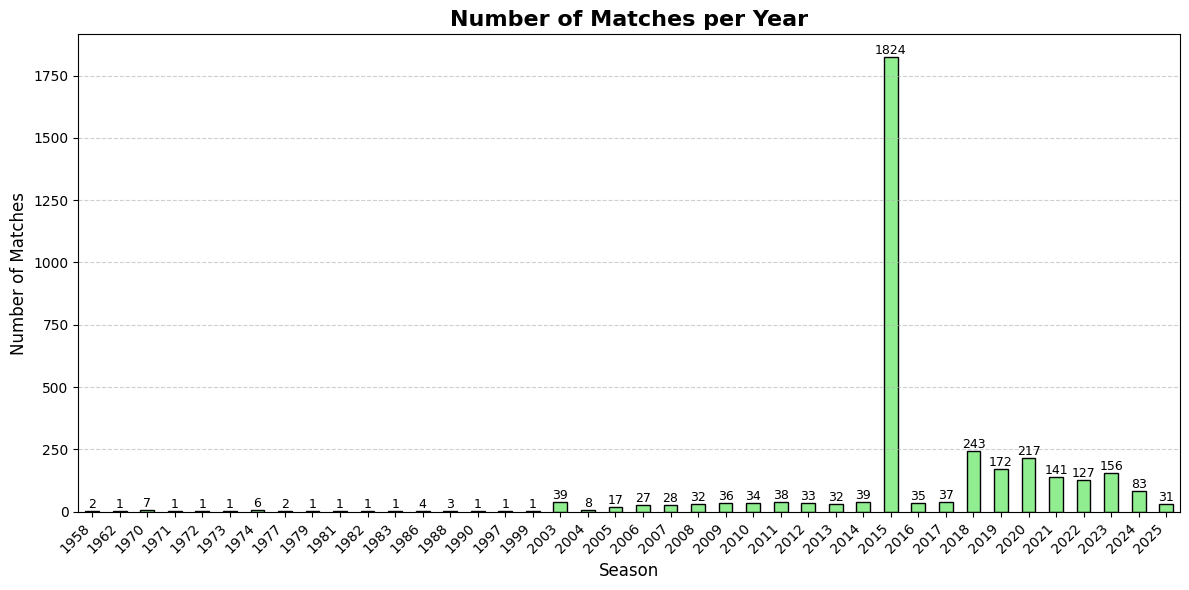

In [78]:
import matplotlib.pyplot as plt

# Check if df_comp exists in the current environment
if "df_comp" not in globals():
    raise RuntimeError("df_comp not found. Please run cell \"1.3) Load the saved dataset first\"")

# Count how many competitions exist each year
competitions_per_year = df_comp.groupby("Season_Start")["Competition"].nunique()

# Sum of matches per year
matches_per_year = df_comp.groupby("Season_Start")["Matches"].sum()

# Plot: number of competitions per year
plt.figure(figsize=(12,6))
bars = competitions_per_year.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Number of Competitions per Year", fontsize=16, weight="bold")
plt.ylabel("Number of Competitions", fontsize=12)
plt.xlabel("Season", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Add values above bars
for i, v in enumerate(competitions_per_year):
    plt.text(i, v + 0.05, str(v), ha="center", va="bottom", fontsize=10, color="black")

plt.tight_layout()
plt.show()

# Plot: number of matches per year
plt.figure(figsize=(12,6))
bars = matches_per_year.plot(kind="bar", color="lightgreen", edgecolor="black")

plt.title("Number of Matches per Year", fontsize=16, weight="bold")
plt.ylabel("Number of Matches", fontsize=12)
plt.xlabel("Season", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Add values above bars
for i, v in enumerate(matches_per_year):
    plt.text(i, v + 0.1, str(v), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


### 1.4) Info on Competition and Matches Gender  

Overview of the competitions by gender. A simple print lists the unique gender values available while a bar chart visualizes how many competitions exist for each gender category.  

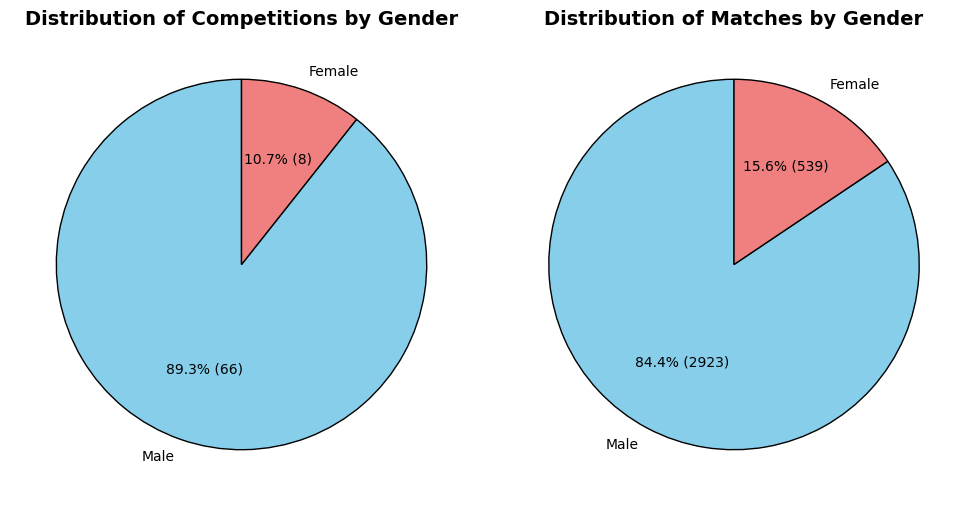

In [79]:
import matplotlib.pyplot as plt

# Check if df_comp exists in the current environment
if "df_comp" not in globals():
    raise RuntimeError("df_comp not found. Please run cell \"1.3) Load the saved dataset first\"")

# Compute the number of competitions per gender
gender_counts = df_comp["Gender"].value_counts()

# Compute the number of matches per gender
matches_per_gender = df_comp.groupby("Gender")["Matches"].sum()

# Force a consistent order of categories (Male first, Female second)
order = ["Male", "Female"]
gender_counts = gender_counts.reindex(order).dropna()
matches_per_gender = matches_per_gender.reindex(order).dropna()

# Define consistent colors for genders
color_map = {"Male": "skyblue", "Female": "lightcoral"}

# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot 1: Competitions by gender
gender_counts.plot(
    kind="pie",
    labels=gender_counts.index,                                         # labels are the gender categories
    autopct=lambda p: f"{p:.1f}% ({int(p*sum(gender_counts)/100)})",    # show % and absolute count
    startangle=90,                                                      # rotate the chart so it starts from the top
    counterclock=True,                                                  # wedges are drawn counterclockwise
    colors=[color_map[g] for g in gender_counts.index],                 # apply consistent colors
    wedgeprops={"edgecolor": "black"},                                  # black borders around wedges
    ax=axes[0]                                                          # plot in the first subplot
)
axes[0].set_title("Distribution of Competitions by Gender", fontsize=14, fontweight="bold")
axes[0].set_ylabel("")  # remove y-axis label

# Plot 2: Matches by gender
matches_per_gender.plot(
    kind="pie",
    labels=matches_per_gender.index,                                       # labels are the gender categories
    autopct=lambda p: f"{p:.1f}% ({int(p*sum(matches_per_gender)/100)})",  # show % and absolute count
    startangle=90,                                                         # same rotation as the first chart
    counterclock=True,                                                     # same direction to keep wedges aligned
    colors=[color_map[g] for g in matches_per_gender.index],               # apply consistent colors
    wedgeprops={"edgecolor": "black"},                                     # black borders around wedges
    ax=axes[1]                                                             # plot in the second subplot
)
axes[1].set_title("Distribution of Matches by Gender", fontsize=14, fontweight="bold")
axes[1].set_ylabel("")  # remove y-axis label

# Adjust layout so titles fit good
plt.tight_layout()

# Display the figure
plt.show()


## 2) Examination of `Shot` events and StatsBomb xG

Below, the code focuses on retrieving **AS Roma matches** and exploring the structure of the **shot events** within them.  
The goal is to understand how a shot is represented in the StatsBomb data, including its attributes, xG values, and the underlying data that composes the event itself.  


In [80]:
from statsbombpy import sb
import pandas as pd
from tqdm import tqdm

# Load open-data competitions
comps = sb.competitions().copy()

roma_matches = []

# Iterate over (competition_id, season_id) pairs
for comp_id, season_id in tqdm(comps[['competition_id', 'season_id']].itertuples(index=False),
                               total=len(comps), desc="Fetching matches"):
    try:
        matches = sb.matches(competition_id=comp_id, season_id=season_id)

        # Filter matches where Roma is either home or away
        mask = (
            matches['home_team'].str.contains('AS Roma', case=False, na=False) |
            matches['away_team'].str.contains('AS Roma', case=False, na=False)
        )

        pm = matches.loc[mask]
        if not pm.empty:
            roma_matches.append(pm)

    except Exception as e:
        tqdm.write(f"Warning: failed comp={comp_id}, season={season_id} -> {e}")
        continue

# Concatenate into a single DataFrame, sort by date, reset index
if roma_matches:
    roma_matches = (
        pd.concat(roma_matches, ignore_index=True)
          .drop_duplicates(subset='match_id')
          .sort_values(by='match_date', ascending=True)
          .reset_index(drop=True)
    )
else:
    roma_matches = pd.DataFrame()

print(f"Total Roma matches found: {len(roma_matches)}")
roma_matches.head()


Fetching matches: 100%|██████████| 75/75 [00:00<00:00, 129.81it/s]

Total Roma matches found: 38


,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3878541,2015-08-22,18:00:00.000,Italy - Serie A,2015/2016,Hellas Verona,AS Roma,1,1,available,...,None,1,Regular Season,Stadio Marc''Antonio Bentegodi,Marco Guida,"Rafael Márquez Álvarez, Andrea Mandorlini",Rudi Garcia,1.1.0,2,2
1,3878555,2015-08-30,18:00:00.000,Italy - Serie A,2015/2016,AS Roma,Juventus,2,1,available,...,None,2,Regular Season,Estadio Olímpico,Nicola Rizzoli,Rudi Garcia,Massimiliano Allegri,1.1.0,2,2
2,3878593,2015-09-12,18:00:00.000,Italy - Serie A,2015/2016,Frosinone,AS Roma,0,2,available,...,None,3,Regular Season,Stadio Comunale Matusa,Andrea Gervasoni,Roberto Stellone,Rudi Garcia,1.1.0,2,2
3,3878607,2015-09-20,15:00:00.000,Italy - Serie A,2015/2016,AS Roma,Sassuolo,2,2,available,...,None,4,Regular Season,Estadio Olímpico,Davide Massa,Rudi Garcia,Eusebio Di Francesco,1.1.0,2,2
4,3879545,2015-09-23,20:45:00.000,Italy - Serie A,2015/2016,Sampdoria,AS Roma,2,1,available,...,None,5,Regular Season,Stadio Comunale Luigi Ferraris,Luca Banti,Walter Zenga,Rudi Garcia,1.1.0,2,2


In [91]:
import random as rand

# Random Roma match
match = roma_matches.iloc[rand.randint(0, len(roma_matches))]
match_id = int(match['match_id'])

# Display match columns
print("Match columns:")
roma_matches[roma_matches["match_id"] == match_id].columns.tolist()


Match columns:


['match_id',
 'match_date',
 'kick_off',
 'competition',
 'season',
 'home_team',
 'away_team',
 'home_score',
 'away_score',
 'match_status',
 'match_status_360',
 'last_updated',
 'last_updated_360',
 'match_week',
 'competition_stage',
 'stadium',
 'referee',
 'home_managers',
 'away_managers',
 'data_version',
 'shot_fidelity_version',
 'xy_fidelity_version']

In [92]:
# Load events and keep only shots
events = sb.events(match_id=match_id)
shots = events[events['type'] == 'Shot']

# Print shot event columns
print("Shot event columns")
shots.columns.tolist(), len(shots.columns.tolist())

Shot event columns


(['50_50',
  'ball_receipt_outcome',
  'ball_recovery_recovery_failure',
  'block_deflection',
  'carry_end_location',
  'clearance_aerial_won',
  'clearance_body_part',
  'clearance_head',
  'clearance_left_foot',
  'clearance_right_foot',
  'counterpress',
  'dribble_outcome',
  'dribble_overrun',
  'duel_outcome',
  'duel_type',
  'duration',
  'foul_committed_advantage',
  'foul_committed_card',
  'foul_committed_offensive',
  'foul_committed_penalty',
  'foul_committed_type',
  'foul_won_advantage',
  'foul_won_defensive',
  'foul_won_penalty',
  'goalkeeper_body_part',
  'goalkeeper_end_location',
  'goalkeeper_outcome',
  'goalkeeper_position',
  'goalkeeper_technique',
  'goalkeeper_type',
  'id',
  'index',
  'interception_outcome',
  'location',
  'match_id',
  'minute',
  'miscontrol_aerial_won',
  'off_camera',
  'out',
  'pass_aerial_won',
  'pass_angle',
  'pass_assisted_shot_id',
  'pass_body_part',
  'pass_cross',
  'pass_cut_back',
  'pass_deflected',
  'pass_end_locat

In [93]:
from statsbombpy import sb
import pandas as pd

# First Roma match in the dataframe
if 'match' not in globals() or 'match_id' not in globals():
    match = roma_matches.iloc[0]
    match_id = int(match['match_id'])

# Match info
print("\nMATCH INFO")
print("----------")
print(f"Match ID           : {match.get('match_id', '')}")
print(f"Competition        : {match.get('competition', '')}")
print(f"Competition Stage  : {match.get('competition_stage', '')}")
print(f"Season             : {match.get('season', '')}")
print(f"Match Week         : {match.get('match_week', '')}")
print(f"Date               : {pd.to_datetime(match.get('match_date')).date() if 'match_date' in match else ''}")
print(f"Kick-off           : {match.get('kick_off', '')[:5]}")
print(f"Match              : {match.get('home_team', '')} vs {match.get('away_team', '')}")
print(f"Score              : {match.get('home_score', '')} - {match.get('away_score', '')}")
print(f"Stadium            : {match.get('stadium', '')}")
print(f"Referee            : {match.get('referee', '')}")
print("Managers           :")
print(f"  {match.get('home_team', ''):<15} -> {match.get('home_managers', '')}")
print(f"  {match.get('away_team', ''):<15} -> {match.get('away_managers', '')}")

# Load events and keep only shots
events = sb.events(match_id=match_id)
shots = events[events['type'] == 'Shot'].copy()
# Compact columns for display (StatsBomb uses underscores in flattened columns)
cols = [
    'period','minute','second','team','player','location',
    'shot_type','shot_body_part','shot_outcome'
]
if 'shot_statsbomb_xg' in shots.columns:
    cols.append('shot_statsbomb_xg')

cols = [c for c in cols if c in shots.columns]  # keep only available

print("\nSHOTS")
print("------")
with pd.option_context('display.max_colwidth', 80, 'display.width', 140):
    if len(shots) == 0:
        print("No shots found for this match.")
    else:
        print(shots[cols].to_string(index=False))



MATCH INFO
----------
Match ID           : 3879717
Competition        : Italy - Serie A
Competition Stage  : Regular Season
Season             : 2015/2016
Match Week         : 23
Date               : 2016-02-02
Kick-off           : 21:45
Match              : Sassuolo vs AS Roma
Score              : 0 - 2
Stadium            : MAPEI Stadium - Città del Tricolore
Referee            : Gianpaolo Calvarese	
Managers           :
  Sassuolo        -> Eusebio Di Francesco
  AS Roma         -> Luciano Spalletti

SHOTS
------
 period  minute  second     team                   player      location shot_type shot_body_part shot_outcome  shot_statsbomb_xg
      1       3      52 Sassuolo           Nicola Sansone  [94.1, 22.9] Open Play     Right Foot        Saved           0.009810
      1      10      34  AS Roma            Mohamed Salah [100.5, 51.4] Open Play      Left Foot         Goal           0.055362
      1      22      21  AS Roma         Radja Nainggolan [103.8, 50.1] Open Play     Right

Below, the **shot events** from the match above are projected onto a **StatsBomb pitch** using `mplsoccer` library. 
The pitch dimensions are aligned with StatsBomb’s coordinate system (120x80), ensuring that every shot is displayed in the correct position.  

- **Non-goals** (missed, saved, blocked) are shown in **red**.  
- **Goals** are shown in **green**.  
- The **size of each marker** is proportional to the **xG value** of the shot, highlighting the likelihood of scoring.  

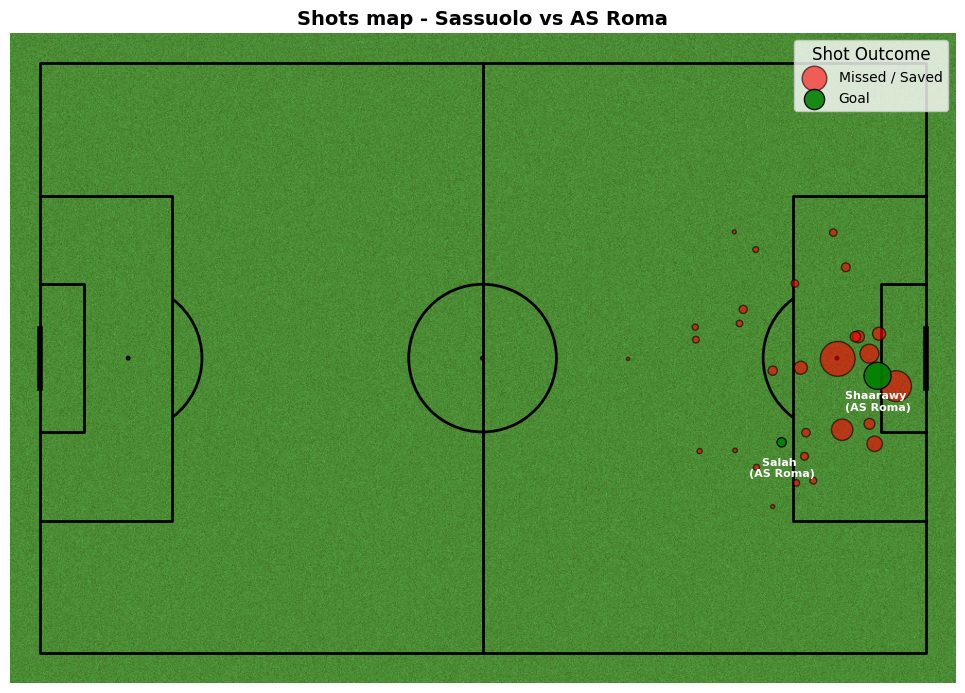

In [94]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt

# Create pitch
pitch = Pitch(pitch_type='statsbomb', line_color='black', pitch_color='grass')
fig, ax = pitch.draw(figsize=(10, 7))

# Separate goals and non-goals
goals = shots[shots['shot_outcome'] == 'Goal']
others = shots[shots['shot_outcome'] != 'Goal']

# Plot non-goals
pitch.scatter(
    others['location'].apply(lambda x: x[0]),
    others['location'].apply(lambda x: x[1]),
    s=others['shot_statsbomb_xg']*800 if 'shot_statsbomb_xg' in others else 100,
    c='red', edgecolors='black', alpha=0.6, ax=ax, label='Missed / Saved'
)

# Plot goals
pitch.scatter(
    goals['location'].apply(lambda x: x[0]),
    goals['location'].apply(lambda x: x[1]),
    s=goals['shot_statsbomb_xg']*800 if 'shot_statsbomb_xg' in goals else 100,
    c='green', edgecolors='black', alpha=0.9, ax=ax, label='Goal'
)

# Add player names above the goals
for _, row in goals.iterrows():

    x, y = row['location']

    player_name = row['player'].split(' ')[-1]
    player_team = row['team']
    name_team = f"{player_name} \n({player_team})"

    ax.text(x, y+5, name_team, color='white', fontsize=8, fontweight='bold',
            ha='center', va='bottom', alpha=1)

# Titles
plt.title(f"Shots map - {match.get('home_team', '')} vs {match.get('away_team', '')}", 
          fontsize=14, fontweight='bold')
plt.legend(
    fontsize=10,
    title="Shot Outcome",
    title_fontsize='12'
)
plt.show()


### Goals and Shooting Angles Visualization

In the plot below there are only displayed the **goals** from the dataset. For each goal, the **shooting angle** is calcoled, formed between the shooter and the two goalposts (at `y=36` and `y=44` in the StatsBomb coordinate system).  
This visualization helps to understand how the position of the shooter affects the width of the goal opening, which is a key feature in expected goals (xG) models.


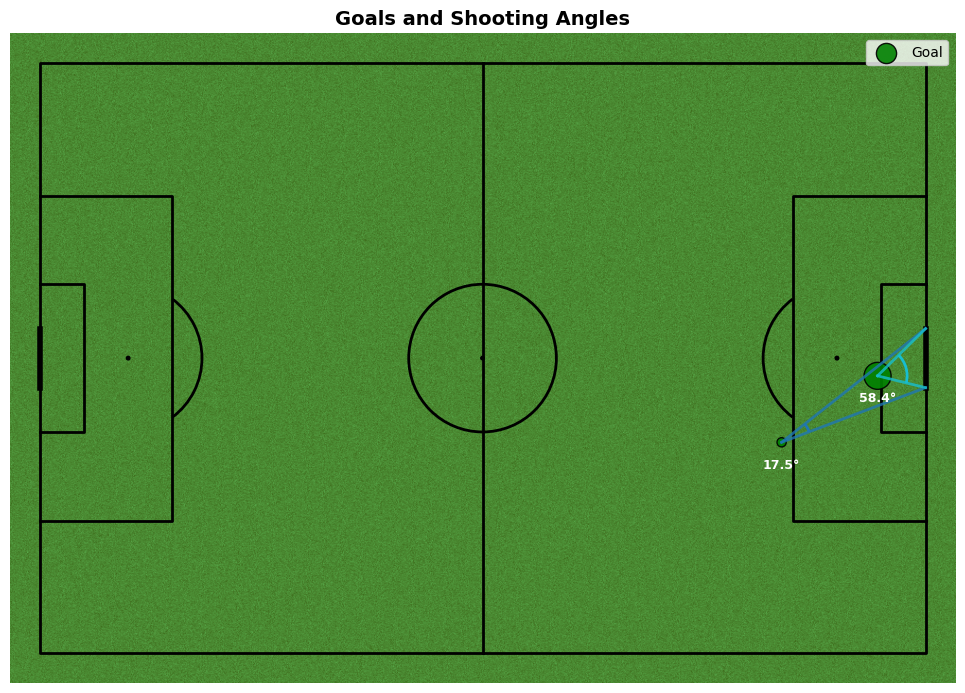

In [ ]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import numpy as np

# Goal dimensions (StatsBomb units: 120x80)
GOAL_X, GOAL_Y_TOP, GOAL_Y_BOTTOM, GOAL_CENTER_Y = 120, 44, 36, 40

# Compute shooting angle (radians)
def compute_angle(x, y):
    """
    Compute the visible angle of the goal from the shot location.
    
    Idea:
    - From the shooter's point (x,y), we draw two lines: one to the top post and one to the bottom post
    - The wider the separation between these two lines, the larger the goal appears
    - If the player is behind the goal line, the angle is set to zero

    Why atan2?
    - atan2(dy, dx) gives the angle of a line with respect to the x-axis
    - Unlike arctan, atan2 considers the signs of dx and dy, so it works correctly in all directions
    - We compute the angle to the top and bottom posts separately and then take their difference

    Range of resulting angles: [0, π]
    """
    dx = GOAL_X - x
    if dx <= 0:  # if the shot is taken beyond or on the goal line
        return 0.0
    angle_top = np.arctan2((GOAL_Y_TOP - y), dx)
    angle_bottom = np.arctan2((GOAL_Y_BOTTOM - y), dx)
    return abs(angle_top - angle_bottom)

# Create pitch
pitch = Pitch(pitch_type='statsbomb', line_color='black', pitch_color='grass')
fig, ax = pitch.draw(figsize=(10, 7))

# Filter goals
goals = shots[shots['shot_outcome'] == 'Goal']

# Scatter plot (size = xG if available)
s = goals['shot_statsbomb_xg']*800 if 'shot_statsbomb_xg' in goals else 120
pitch.scatter(goals['location'].str[0],
              goals['location'].str[1],
              s=s, c='green', edgecolors='black', alpha=0.9, ax=ax, label='Goal')

# Colors by player
players = goals['player'].unique()
cmap = plt.cm.get_cmap('tab10', len(players))
player_colors = {p: cmap(i) for i, p in enumerate(players)}

# Draw angles
for _, row in goals.iterrows():
    x, y = row['location']
    dx = GOAL_X - x
    if dx <= 0:  
        continue  # skip invalid cases

    # Angles to posts (only for arc)
    top_angle = np.degrees(np.arctan2(GOAL_Y_TOP - y, dx))
    bottom_angle = np.degrees(np.arctan2(GOAL_Y_BOTTOM - y, dx))

    # Total opening angle
    theta_deg = np.degrees(compute_angle(x, y))

    # Player color
    color = player_colors[row['player']]

    # Lines to posts
    ax.plot([x, GOAL_X], [y, GOAL_Y_BOTTOM], color=color, lw=2, alpha=0.8)
    ax.plot([x, GOAL_X], [y, GOAL_Y_TOP], color=color, lw=2, alpha=0.8)

    # Arc (span between bottom and top)
    arc = Arc((x, y), 8, 8, angle=0,
              theta1=min(top_angle, bottom_angle),
              theta2=max(top_angle, bottom_angle),
              color=color, lw=2)
    ax.add_patch(arc)

    # Angle text
    ax.text(x, y+4, f"{theta_deg:.1f}°",
            color='white', fontsize=9, fontweight='bold',
            ha='center', va='bottom')

# Title & legend
plt.title("Goals and Shooting Angles", fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.show()
